
# Clasificación de Imágenes de Animales

**Objetivo**: Entrenar un modelo de redes neuronales convolucionales (CNN) para clasificar imágenes de animales utilizando un dataset organizado en subdirectorios.

El dataset contiene imágenes organizadas por carpetas, donde cada carpeta representa una categoría (e.g., `antelope`, `bear`). Esta libreta está estructurada de la siguiente manera:

1. Carga del dataset y preprocesamiento de las imágenes.
2. Construcción de un modelo de CNN utilizando TensorFlow/Keras.
3. Entrenamiento del modelo y ajuste de hiperparámetros.
4. Evaluación del rendimiento del modelo con métricas y visualizaciones.


In [30]:

# Importando las bibliotecas necesarias
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras import layers



## Carga del Dataset

El dataset está organizado en subdirectorios dentro de `animals/animals`. Cada subdirectorio corresponde a una categoría de animal.


In [21]:

# Ruta del dataset (ajustar según la ubicación real)
base_path = "./animals/animals"  # Directorio raíz de las imágenes

# Explorando las categorías disponibles
categories = os.listdir(base_path)
print(f"Categorías detectadas: {len(categories)}")
print(categories[:10])  # Mostrando las primeras 10 categorías como ejemplo

# Cargar modelo .keras
model = keras.models.load_model('model.keras')

Categorías detectadas: 90
['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat']


C:\Users\mariodm1\AppData\Roaming\Python\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



## Preprocesamiento de las Imágenes

Normalizamos las imágenes y aplicamos aumentación de datos para mejorar la generalización del modelo.


In [22]:

# Generador de imágenes con aumentación
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Separar un porcentaje para validación
)

# Generadores de datos para entrenamiento y validación
train_data = image_gen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = image_gen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


## Creació del model

In [39]:
model = Sequential()

model.add(layers.Flatten(input_shape=(150, 150, 3)))  # Update the input shape
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(90, activation='relu'))  # Update the number of units to match the number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10, batch_size=32)

C:\Users\mariodm1\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 48s 352ms/step - accuracy: 0.0121 - loss: 10.1188 - val_accuracy: 0.0111 - val_loss: 9.7113
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 348ms/step - accuracy: 0.0092 - loss: 9.7487 - val_accuracy: 0.0167 - val_loss: 9.6935
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 346ms/step - accuracy: 0.0182 - loss: 9.6085 - val_accuracy: 0.0111 - val_loss: 9.5667
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 348ms/step - accuracy: 0.0141 - loss: 9.4892 - val_accuracy: 0.0185 - val_loss: 9.5508
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 48s 353ms/step - accuracy: 0.0289 - loss: 9.5356 - val_accuracy: 0.0278 - val_loss: 9.5658
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 51s 379ms/step - accuracy: 0.0234 - loss: 9.4463 - val_accuracy: 0.0130 - val_loss: 9.5621
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 374ms/step - accuracy: 0.0204 - loss: 9.5474 - val_accuracy: 0.0231 - val_loss: 9.5504
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 49s 360ms/step - accuracy: 0.0217 - loss: 

## Evaluar el entrenamiento

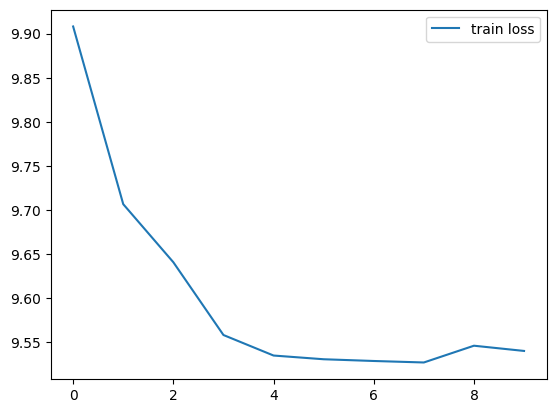

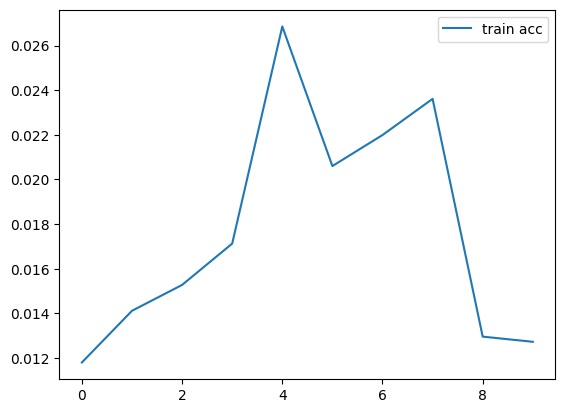

In [40]:
plt.plot(history.history['loss'], label='train loss')
plt.legend()
plt.show()
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()

## Evaluar el modelo

In [41]:
model.evaluate(val_data)

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.0154 - loss: 9.5169


[9.567887306213379, 0.015740741044282913]

In [44]:
# Predecir una imagen
img = keras.preprocessing.image.load_img(
    "./animals/animals/rhinoceros/2ef5023060.jpg", target_size=(150, 150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(categories[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
This image most likely belongs to turtle with a 100.00% confidence.


## Guardar el modelo

In [38]:
model.save('model.keras')